In [3]:
#Importamos la librería pandas que necesitamos para la lectura, conversión y limpieza de los datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np
import re 

#Importamos librerías necesarias para la visualización
# -----------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Imputación de nulos usando métodos avanzados estadísticos
# -----------------------------------------------------------------------
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

import os
import sys
sys.path.append("../")

pd.set_option('display.max_columns', None) # para poder visualizar todas las columnas de los DataFrames
# pd.set_option('display.max_rows', None) # para poder visualizar todas las filas de los DataFrames

In [4]:
#Abrimos el csv y lo convertimos a un DataFrame.
df_HR= pd.read_csv('../ETL/data/output_data/df_HR_limpio.csv')
df_HR.head(10)

,Age,Attrition,BusinessTravel,DailyRate,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,DateBirth,RemoteWork
0,51,No,Unknown,684.0,6,3,Unknown,"162,0",1,M,51.0,3,5,Research Director,3,Unknown,19537.000000,6462,7,No,13,"3,0",3,0,Unknown,5,3,20,15,15,1972,yes
1,52,No,Unknown,699.0,1,4,Life Sciences,"259,0",3,M,65.0,2,5,Manager,3,Unknown,19999.000000,5678,0,Unknown,14,"3,0",1,1,"34,0",5,3,33,11,9,1971,yes
2,42,No,travel_rarely,532.0,4,2,Technical Degree,"319,0",3,M,58.0,3,5,Manager,4,Married,19232.000000,4933,1,No,11,"3,0",4,0,"22,0",3,3,22,11,15,1981,yes
3,47,No,travel_rarely,359.0,2,4,Medical,Unknown,1,F,82.0,3,4,Research Director,3,Married,17169.000000,26703,3,Unknown,19,"3,0",2,2,Unknown,2,3,20,5,6,1976,no
4,48,No,Unknown,117.0,22,3,Medical,"1900,0",4,F,58.0,3,4,Manager,4,Unknown,17174.000000,2437,3,No,11,"3,0",2,1,Unknown,3,3,22,4,7,1975,yes
5,59,No,Unknown,1435.0,25,3,Life Sciences,"81,0",1,F,99.0,3,3,Sales Executive,1,Unknown,6463.923077,2354,7,Unknown,11,"3,0",4,0,"28,0",3,2,21,7,9,1964,yes
6,42,No,travel_rarely,635.0,1,1,Unknown,"387,0",2,M,99.0,3,2,Sales Executive,3,Married,6463.923077,24532,1,No,25,"4,0",3,0,"20,0",3,3,20,11,6,1981,no
7,41,No,travel_frequently,840.0,9,3,Unknown,"999,0",1,M,64.0,3,5,Research Director,3,Unknown,6463.923077,3735,2,No,17,"3,0",2,1,"21,0",2,4,18,0,11,1982,no
8,41,No,non-travel,247.0,7,1,Unknown,"1035,0",2,F,55.0,1,5,Research Director,3,Unknown,19973.000000,20284,1,No,22,"4,0",2,2,Unknown,3,3,21,5,10,1982,no
9,41,Yes,travel_rarely,1360.0,12,3,Unknown,"58,0",2,F,49.0,3,5,Research Director,3,Married,19545.000000,16280,1,No,12,"3,0",4,0,Unknown,0,3,22,15,8,1982,no


In [5]:
df_HR.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'DistanceFromHome',
       'Education', 'EducationField', 'EmployeeNumber',
       'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement',
       'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus',
       'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'OverTime',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsSinceLastPromotion',
       'YearsWithCurrManager', 'DateBirth', 'RemoteWork'],
      dtype='object')

In [6]:
df_HR['JobSatisfaction'].dtype

dtype('int64')

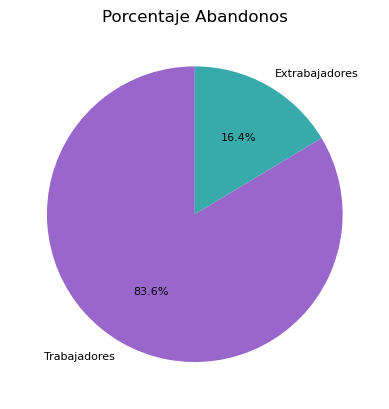

In [7]:
colores_mako = sns.color_palette('mako', 2)

# Ajustar manualmente el color violeta para "No" (asumimos que es el último color)
colores_mako = list(colores_mako)  # Convertimos a lista para modificar
colores_mako[0] = (0.6, 0.4, 0.8)  # Ajustar los valores RGB para aclarar el color violeta

attrition_counts = df_HR['Attrition'].value_counts()
labels = ['Trabajadores', 'Extrabajadores']

plt.pie(attrition_counts, labels=labels,
        autopct='%1.1f%%',
        colors=colores_mako,
        textprops={'fontsize': 8},
        startangle=90)

plt.title('Porcentaje Abandonos');

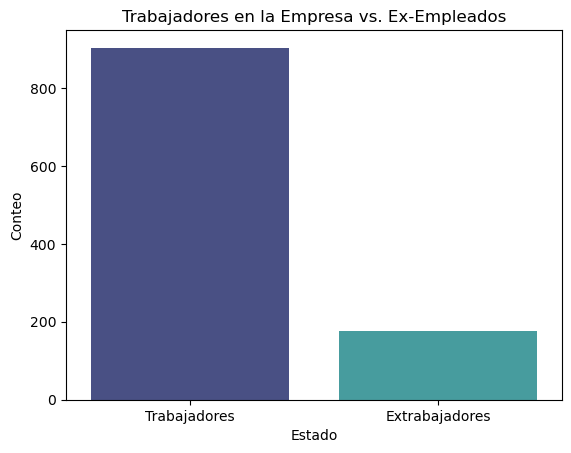

In [8]:
ax = sns.countplot(x='Attrition', data=df_HR, palette='mako', order=['No', 'Yes'])

# Cambiar las etiquetas del eje X
ax.set_xticklabels(['Trabajadores', 'Extrabajadores'])

# Ajustar el título y las etiquetas de los ejes
plt.title('Trabajadores en la Empresa vs. Ex-Empleados')
plt.xlabel('Estado')
plt.ylabel('Conteo');

In [9]:
df_HR['Attrition'].value_counts()

Attrition
No     903
Yes    177
Name: count, dtype: int64

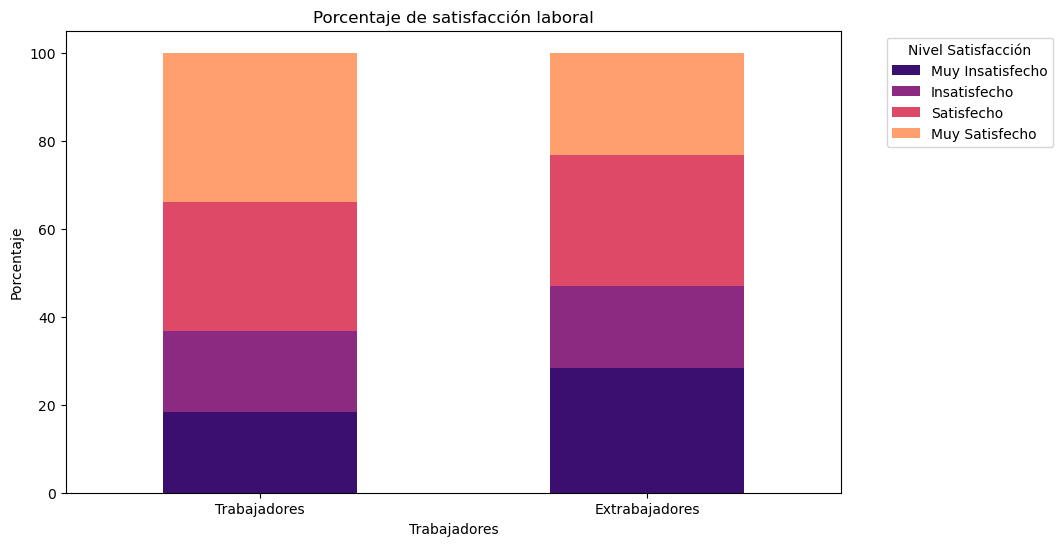

In [10]:
trabajadores = df_HR[df_HR['Attrition'] == 'No']
extrabajadores = df_HR[df_HR['Attrition'] == 'Yes']

# Calcular los porcentajes de satisfacción laboral para trabajadores
trabajadores = trabajadores['JobSatisfaction'].value_counts(normalize=True).sort_index() * 100
# Calcular los porcentajes de satisfacción laboral para extrabajadores
extrabajadores = extrabajadores['JobSatisfaction'].value_counts(normalize=True).sort_index() * 100

# Crear un DataFrame con los porcentajes
df_estado_trabajadores = pd.DataFrame({
    'Trabajadores': trabajadores,
    'Extrabajadores': extrabajadores
}).T

# Crear el gráfico de barras apiladas
colors = plt.cm.magma([0.2, 0.4, 0.6, 0.8])
ax = df_estado_trabajadores.plot(kind='bar', stacked=True, color=colors, figsize=(10, 6))

# Ajustar el título y las etiquetas de los ejes
plt.title('Porcentaje de satisfacción laboral')
plt.xlabel('Trabajadores')
plt.ylabel('Porcentaje')
plt.xticks(rotation=0)

# Mover la leyenda fuera del gráfico
plt.legend(['Muy Insatisfecho', 'Insatisfecho', 'Satisfecho', 'Muy Satisfecho'], title='Nivel Satisfacción', bbox_to_anchor=(1.05, 1), loc='upper left');
